In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='facebook/opt-350m'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
lr = 5.0e-5
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, weight decay {wd}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       accumulation_steps=2,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search facebook/opt-350m, learning rate 5e-05, weight decay 0.1


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.5799	Val Loss:	0.5465	Accuracy:	0.7549	F1:	0.6648
2 / 30: Train Loss:	0.2832	Val Loss:	0.5769	Accuracy:	0.7396	F1:	0.4252
3 / 30: Train Loss:	0.3086	Val Loss:	0.5796	Accuracy:	0.7396	F1:	0.4252
4 / 30: Train Loss:	0.2987	Val Loss:	0.5784	Accuracy:	0.7396	F1:	0.4252
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.53      0.45      0.49       119
      struct       0.82      0.86      0.84       338

    accuracy                           0.75       457
   macro avg       0.68      0.66      0.66       457
weighted avg       0.74      0.75      0.75       457

test results:
              precision    recall  f1-score   support

       bknow       0.62      0.52      0.57        67
      struct       0.84      0.89      0.86       189

    accuracy                           0.79       256
   macro avg       0.73      0.71      0.72       256
weighted av

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.5807	Val Loss:	0.5369	Accuracy:	0.7440	F1:	0.6395
2 / 30: Train Loss:	0.2919	Val Loss:	0.6663	Accuracy:	0.7396	F1:	0.4252
3 / 30: Train Loss:	0.3114	Val Loss:	0.5828	Accuracy:	0.7396	F1:	0.4252
4 / 30: Train Loss:	0.2998	Val Loss:	0.5774	Accuracy:	0.7396	F1:	0.4252
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.51      0.39      0.45       119
      struct       0.80      0.87      0.83       338

    accuracy                           0.74       457
   macro avg       0.66      0.63      0.64       457
weighted avg       0.73      0.74      0.73       457

test results:
              precision    recall  f1-score   support

       bknow       0.66      0.52      0.58        67
      struct       0.84      0.90      0.87       189

    accuracy                           0.80       256
   macro avg       0.75      0.71      0.73       256
weighted av

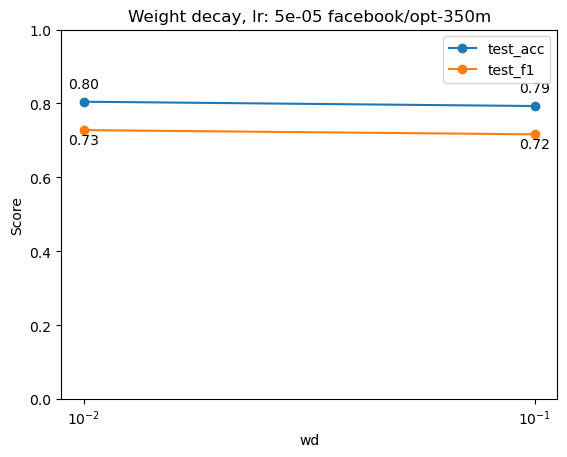

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f